# Introduction: Landmarks

In [18]:
import deltascope as ds
import deltascope.alignment as ut

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize
from scipy.optimize import minimize

import os
import tqdm
import json
import time

Specify matplotlib plots to be interactive

In [2]:
%matplotlib inline

# Import raw data
The user needs to specify the directories containing the data of interest. Each sample type should have a key which corresponds to the directory path. Additionally, each object should have a list that includes the channels of interest.

In [3]:
# --------------------------------
# -------- User input ------------
# --------------------------------

data = {
    # Specify sample type key
    'wt': {
        # Specify path to data directory
        'path': 'Output_01-04-14-43',
        # Specify which channels are in the directory and are of interest
        'channels': ['AT','ZRF']
    }
}

We'll generate a list of pairs of stypes and channels for ease of use.

In [4]:
data_pairs = []
for s in data.keys():
    for c in data[s]['channels']:
        data_pairs.append((s,c))

In [5]:
data_pairs

[('wt', 'AT'), ('wt', 'ZRF')]

We can now read in all datafiles specified by the `data` dictionary above.

In [6]:
D = {}
for s in data.keys():
    D[s] = {}
    for c in data[s]['channels']:
        D[s][c] = ds.read_psi_to_dict(data[s]['path'],c)

100%|██████████| 4/4 [00:00<00:00,  8.66it/s]


# Calculate optimum landmark parameters
Choose a single sample type and channel which will be used as the control to calculate the appropriate size of landmark bins. Typically we use wildtype samples and the AT channel. We will run a parameter sweep of bin sizes using `ds.anumSelect`.

In [7]:
# --------------------------------
# -------- User input ------------
# --------------------------------

# Specify stype to use as control
s_ctrl = 'wt'
# Specify channel to use as control
c_ctrl = 'AT'

# Specify size of theta bins
theta_step = np.pi/4
# Specify the step size when sweeping various alpha bin sizes
astep = 3
# Specify minimum a value 
amn = 2
# Specify maximum a value
amx = 50

In [9]:
%%time
optr = ds.anumSelect(D[s_ctrl][c_ctrl])
optr.param_sweep(theta_step, amn=amn, amx=amx, astep=astep,
                 rnull=np.nan, DT='r')

2 calculation complete
5 calculation complete


/Users/morganschwartz/Code/deltascope/deltascope/__init__.py:1173: RuntimeWarning: Degrees of freedom <= 0 for slice.
  svar = np.nanvar(lmarr,axis=2)


8 calculation complete
11 calculation complete


/Users/morganschwartz/Code/deltascope/deltascope/__init__.py:1179: RuntimeWarning: Degrees of freedom <= 0 for slice.
  Lvar.append(np.nanvar(lmarr[i-1:i+2,t],axis=0))


14 calculation complete
17 calculation complete
20 calculation complete
23 calculation complete
26 calculation complete
29 calculation complete
32 calculation complete
35 calculation complete
38 calculation complete
41 calculation complete
44 calculation complete
47 calculation complete
Parameter sweep complete


Plot result of the parameter sweep to get a sense of the results.

In [10]:
# --------------------------------
# -------- User input ------------
# --------------------------------

# Select degrees of freedom for curve fitting
dof = 5

In [12]:
normalize(optr.Mbv)

ValueError: Expected 2D array, got 1D array instead:
array=[4.0102603  4.23160292 7.36261183 3.69807278 3.28278445 2.10713288
 1.88421175 1.76590483 1.54690221 1.46958735 1.08386808 1.07053568
 1.00833989 1.00562471 1.10313805 0.93610817].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

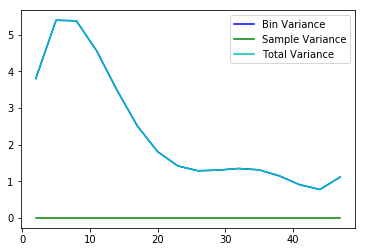

In [14]:
x = np.arange(amn,amx,astep)
fig,ax = plt.subplots()

# Fit a curve to bin variance values
pbv = np.polyfit(x, optr.Mbv, dof)
fbv = np.poly1d(pbv)
ax.plot(x, fbv(x), c='b', label='Bin Variance')

# Fit curve to sample variance values
psv = np.polyfit(x, optr.Msv, dof)
fsv = np.poly1d(psv)
ax.plot(x, fsv(x), c='g', label='Sample Variance')

# Plot sum of sample and bin variances
ax.plot(x, fsv(x)+fbv(x), c='c', label='Total Variance')
ax.legend()

Now we can calculate the optimal bin size with the help of the user specifying a best guess for the optimal value.

In [ ]:
# --------------------------------
# -------- User input ------------
# --------------------------------

# Guess the approximate optimal value
guess = 25

In [ ]:
opt = minimize(fbv+fsv, guess)
ax.axvline(opt.x, c='r', label='Optimum: '+str(np.round(opt.x[0], 2)))
print(opt.x[0])

# Calculate landmark bins
Based on the analysis above, we can select the optimal value of alpha bins.

In [15]:
# --------------------------------
# -------- User input ------------
# --------------------------------

# Pick an integer value for bin number based on results above
anum = 25

# Specify the percentiles which will be used to calculate landmarks
percbins = [50]

Calculate landmark bins based on user input parameters and the previously specified control sample.

In [16]:
lm = ds.landmarks(percbins=percbins, rnull=np.nan)
lm.calc_bins(D[s_ctrl][c_ctrl], anum, theta_step)

print('Alpha bins')
print(lm.acbins)
print('Theta bins')
print(lm.tbins)

Alpha bins
[-50.20199844 -46.01849857 -41.8349987  -37.65149883 -33.46799896
 -29.28449909 -25.10099922 -20.91749935 -16.73399948 -12.55049961
  -8.36699974  -4.18349987   0.           4.18349987   8.36699974
  12.55049961  16.73399948  20.91749935  25.10099922  29.28449909
  33.46799896  37.65149883  41.8349987   46.01849857  50.20199844]
Theta bins
[-3.14159265 -2.35619449 -1.57079633 -0.78539816  0.          0.78539816
  1.57079633  2.35619449  3.14159265]


# Calculate landmarks

In [20]:
lmdf = pd.DataFrame()

# Loop through each pair of stype and channels
for s,c in tqdm.tqdm(data_pairs):
    print(s,c)
    # Calculate landmarks for each sample with this data pair
    for k,df in tqdm.tqdm(D[s][c].items()):
        lmdf = lm.calc_perc(df, k, '-'.join([s,c]), lmdf)
        
# Set timestamp for saving data
tstamp = time.strftime("%m-%d-%H-%M",time.localtime())
        
# Save completed landmarks to a csv file
lmdf.to_csv(tstamp+'_landmarks.csv')

# Save landmark bins to json file
bins = {
    'acbins':list(lm.acbins),
    'tbins':list(lm.tbins)
}
with open(tstamp+'_landmarks_bins.json', 'w') as outfile:
    json.dump(bins, outfile)

  0%|          | 0/1 [00:00<?, ?it/s]

wt AT



  0%|          | 0/1 [00:00<?, ?it/s]

wt ZRF



100%|██████████| 2/2 [00:01<00:00,  1.44it/s]
